In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = (
    3  # context length: how many characters do we take to predict the next one?
)


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])  # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])  # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [72]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5 / 3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.ones((1, n_hidden))
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


tensor(-0.0066) tensor(1.0176)
tensor(0.0030) tensor(1.0371)


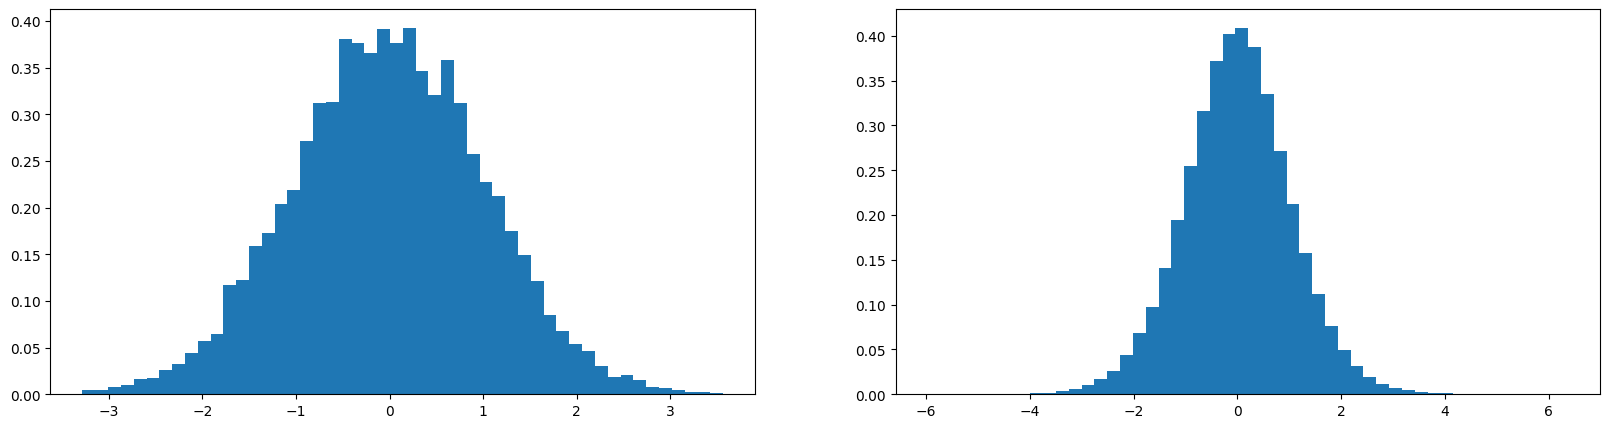

In [61]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [65]:
hpreact.shape

torch.Size([32, 200])

In [67]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [68]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [73]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    emb_cat = emb.view(emb.shape[0], -1)  # concatenate the vectors

    # Linear layer pre-activation
    hidden_pre_act = emb_cat @ W1 + b1  # hidden layer pre-activation

    # Batch normalize the hidden layer pre-activation
    bnmeani = hidden_pre_act.mean(0, keepdim=True)
    bnstdi = hidden_pre_act.std(0, keepdim=True)
    hidden_pre_act = bngain * (hidden_pre_act - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # Non-linearity
    h = torch.tanh(hidden_pre_act)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    # break

      0/ 200000: 3.3401
  10000/ 200000: 2.2846
  20000/ 200000: 2.3284
  30000/ 200000: 2.5253
  40000/ 200000: 1.9592
  50000/ 200000: 2.5090
  60000/ 200000: 2.3124
  70000/ 200000: 2.0885
  80000/ 200000: 2.3997
  90000/ 200000: 2.1687
 100000/ 200000: 1.9234
 110000/ 200000: 2.3111
 120000/ 200000: 1.9855
 130000/ 200000: 2.5203
 140000/ 200000: 2.3359
 150000/ 200000: 2.2478
 160000/ 200000: 2.0123
 170000/ 200000: 1.8866
 180000/ 200000: 1.9666
 190000/ 200000: 1.8665


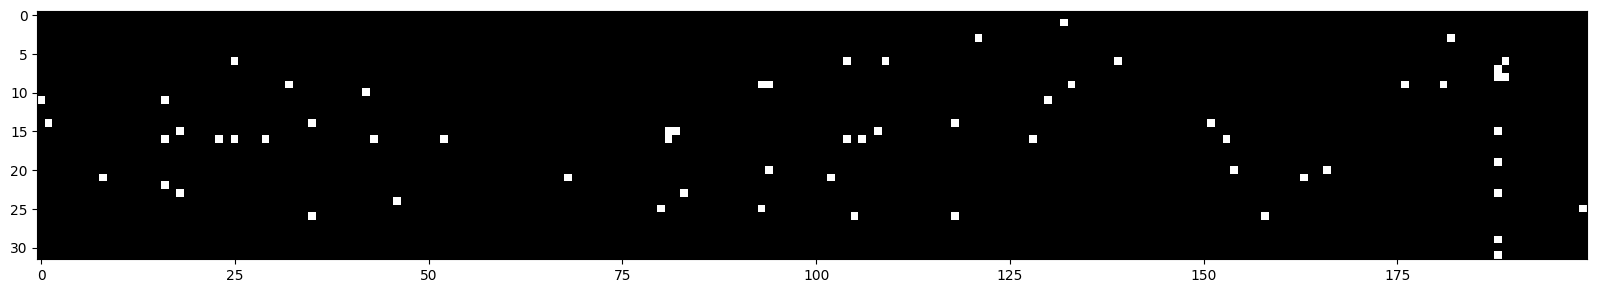

In [50]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation='nearest')

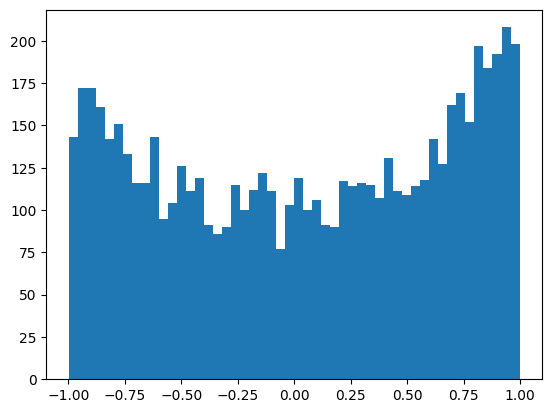

In [51]:
plt.hist(h.view(-1).tolist(), 50);

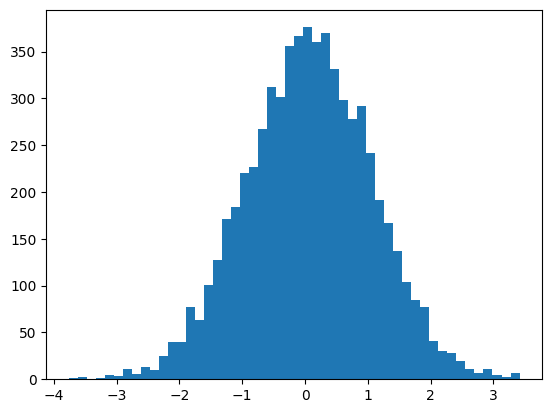

In [52]:
plt.hist(hpreact.view(-1).tolist(), 50);

In [29]:
logits[0]

tensor([-0.0466,  0.0713,  0.0408,  0.0311,  0.0199, -0.0039, -0.0263,  0.0528,
         0.0117, -0.0337, -0.1020, -0.1050,  0.0434,  0.0396,  0.0409, -0.0494,
         0.0589, -0.0159,  0.0335, -0.0671,  0.1769,  0.1197,  0.0399, -0.0758,
         0.0124,  0.1491,  0.0106], grad_fn=<SelectBackward0>)

In [26]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

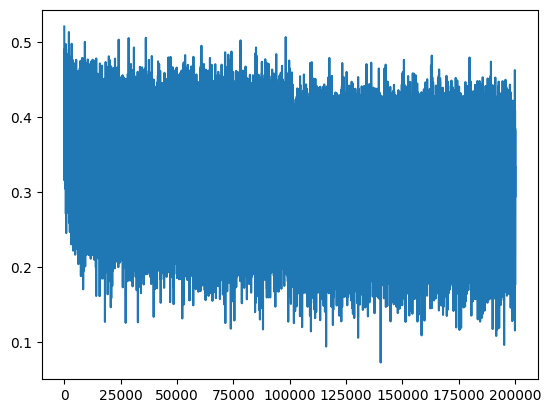

In [55]:
plt.plot(lossi)

In [22]:
# 4 dimensional example of the issue
# logits = torch.tensor([10.0, 0.0, .0, 0.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-13.1856,   5.2025, -26.0641,  -3.4839]),
 tensor([1.0330e-08, 9.9983e-01, 2.6365e-14, 1.6884e-04]),
 tensor(31.2667))

In [71]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    emb_cat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    hidden_pre_act = emb_cat @ W1 + b1
    hidden_pre_act = (
        bngain
        * (hidden_pre_act - hidden_pre_act.mean(0, keepdim=True))
        / hidden_pre_act.std(0, keepdim=True)
        + bnbias
    )
    h = torch.tanh(hidden_pre_act)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 2.0668179988861084
val 2.111778974533081


## loss log
### original:
train 2.1245384216308594 val 2.168196439743042

### fix softmax confidently wrong:
train 2.07 val 2.13

### fix tanh layer too saturated at init:
train 2.0355966091156006 val 2.1026785373687744

### use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693 val 2.106989622116089

### add batch norm layer
train 2.0668270587921143 val 2.104844808578491

In [74]:
# creating modules of what we have covered

In [75]:
# Let's train a deep neural network

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1D:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running "momentum update")
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the  number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1D(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 # 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of paramterts in total
for p in parameters:
    p.requires_grad = True

47024


In [78]:
# same optimization as the last time

max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minbatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward  pass
    emb = C[Xb] # embed the characters  into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER DEBUG: would take out retain_graph
    
    for p in parameters:
        p.grad = None
    
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    if i%10000 == 0: # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break # for testing purpose

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

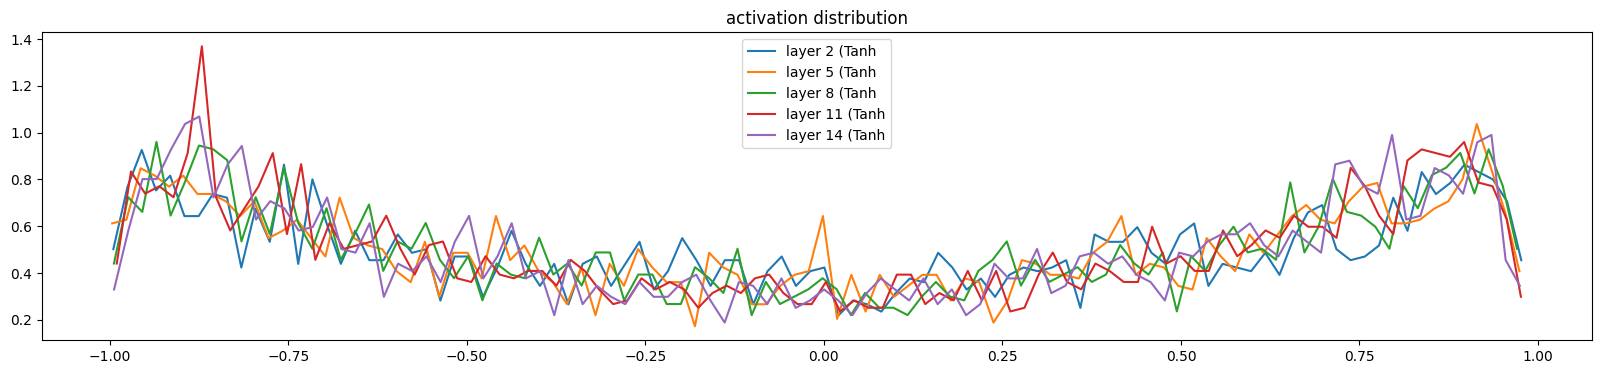

In [ ]:
# visualize histograms of Tanh layers -> activation distribution

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')

plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.640701e-03
layer 5 (      Tanh): mean +0.000000, std 2.245584e-03
layer 8 (      Tanh): mean +0.000000, std 2.045742e-03
layer 11 (      Tanh): mean +0.000000, std 1.983133e-03
layer 14 (      Tanh): mean +0.000000, std 1.952381e-03


Text(0.5, 1.0, 'gradient distribution')

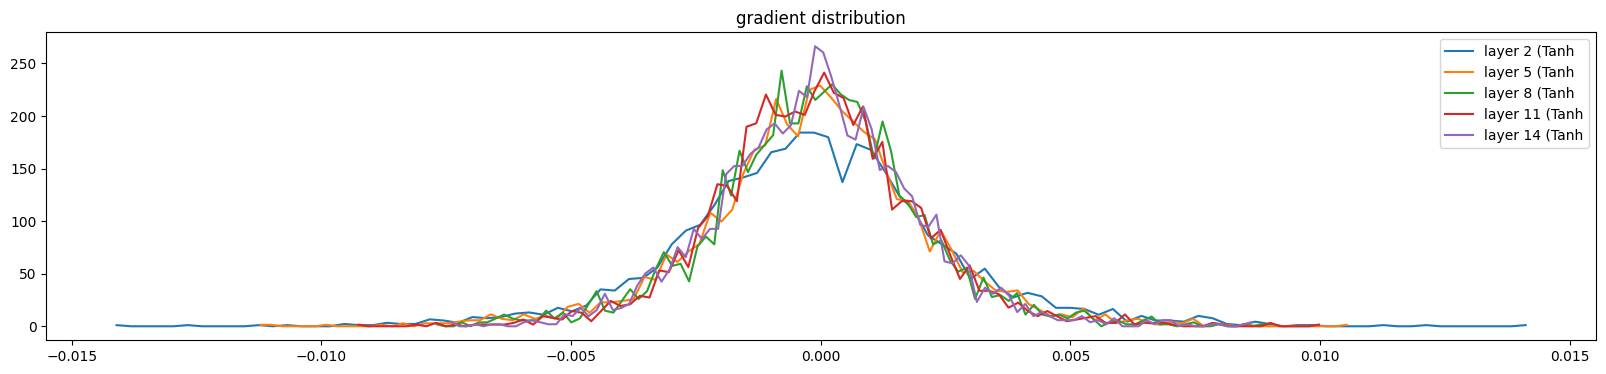

In [80]:
# visualize histograms of Tanh -> gradient distribution

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')

plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.020530e-03 | grad:data ratio 8.012625e-03
weight  (30, 100) | mean +0.000246 | std 9.241067e-03 | grad:data ratio 4.881085e-02
weight (100, 100) | mean +0.000113 | std 7.132873e-03 | grad:data ratio 6.964613e-02
weight (100, 100) | mean -0.000086 | std 6.234299e-03 | grad:data ratio 6.073735e-02
weight (100, 100) | mean +0.000052 | std 5.742181e-03 | grad:data ratio 5.631477e-02
weight (100, 100) | mean +0.000032 | std 5.672202e-03 | grad:data ratio 5.570122e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


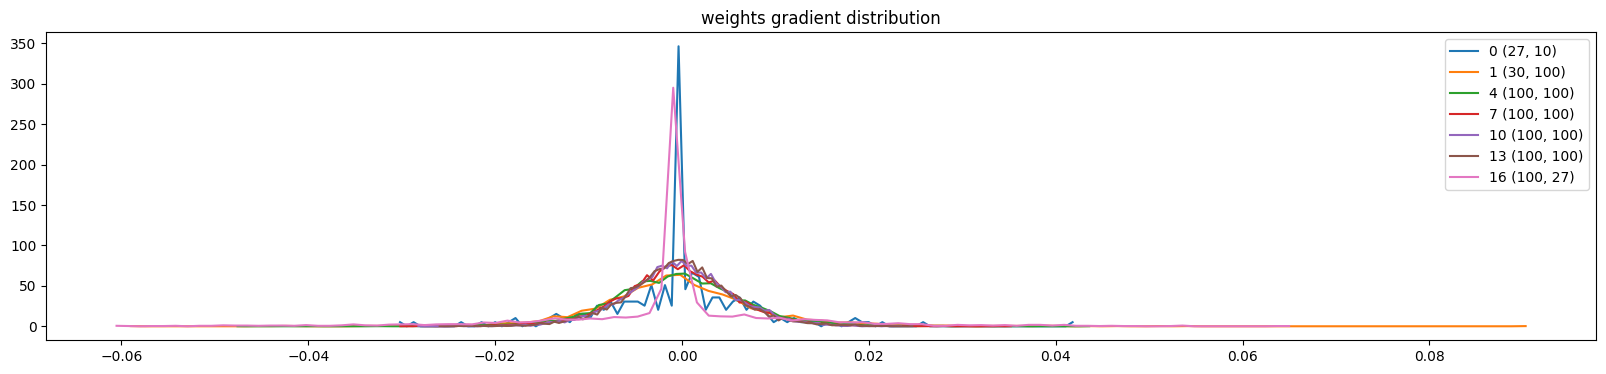

In [81]:
# visualize histograms Tanh -> weights gradient distribution

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')

plt.legend(legends)
plt.title('weights gradient distribution');

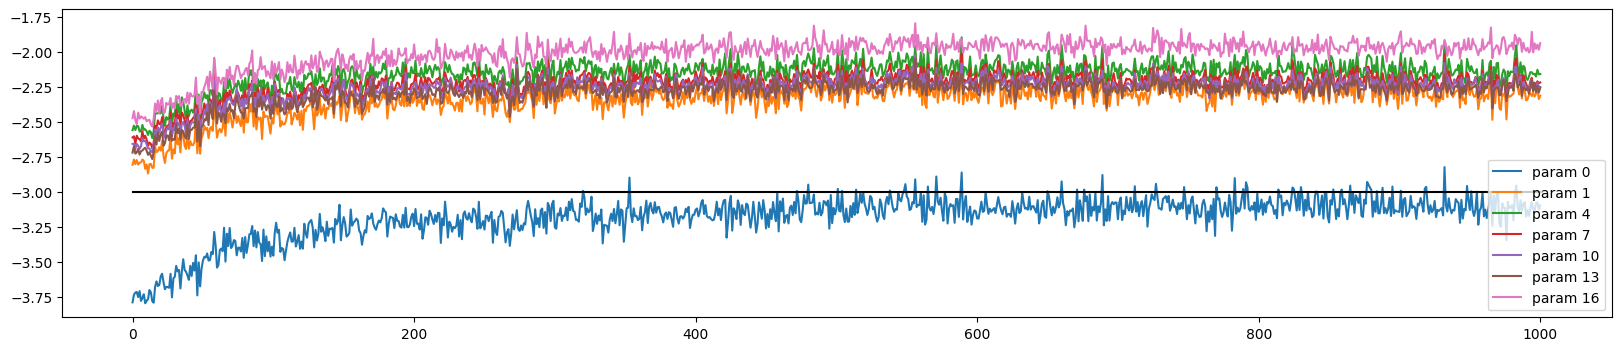

In [83]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param %d" % i)
plt.plot([0, len(ud)], [-3, -3], "k")  # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [84]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())


# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss("train")
split_loss("val")

train 2.4002976417541504
val 2.3982467651367188


In [87]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:

        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1)  # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print("".join(itos[i] for i in out))  # decode and print the generated word

carpah.
qarlileif.
jmrix.
thty.
sacansa.
jazhnte.
dpn.
arciigqeiunellaia.
chriiv.
kalein.
dhlm.
join.
qhinn.
sroin.
arian.
quiqaelogiearyxix.
kaeklinsan.
ed.
ecoia.
gtleley.


In [88]:
layers

In [93]:
emb.shape

torch.Size([1, 3, 10])

In [90]:
x

tensor([[ 3.6905,  2.3953, -0.9549, -0.5469, -0.1648,  1.1132, -1.0816, -0.2432,
         -0.2362,  1.3924, -1.1907, -0.8485,  1.7499, -0.1617,  1.7479,  0.3928,
         -0.9154, -1.0655,  0.8202,  0.5991,  0.6177, -0.7774, -0.3067, -0.9709,
         -0.9585,  0.4964, -0.6315]], grad_fn=<AddBackward0>)